In [32]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from queries import Simbad
import os
import time
import csv
from IPython.display import clear_output
from seaborn import xkcd_palette
blue=xkcd_palette(['windows blue'])[0]
amber=xkcd_palette(['amber'])[0]

% matplotlib inline
#plt.style.use('sm')
#top_path='/DataDisk/datafiles/PGCC_HST/'
top_path='/Users/codydirks/PGCC/'

class LineInfo(object):
    def __init__(self,dat_line,err_line):
        dat=dat_line.split()
        self.ion=dat[0]
        self.n=float(dat[1])
        self.b=float(dat[2])
        self.wav=float(dat[3])
        self.v=float(dat[4])
        self.n_flag=int(dat[5])
        self.b_flag=int(dat[6])
        self.v_flag=int(dat[7])
        self.eqw=float(dat[8])
        self.tot_eqw=float(dat[9])
        
        errs=err_line.split()
        self.n_err=float(errs[0])
        self.b_err=float(errs[1])
        self.v_err=float(errs[2])
        
    def __repr__(self):
        return self.ion
    def __str__(self):
        return self.ion

#Returns angular separation between two Ra/Dec coordinates in degrees
def get_ang_sep(ra1,dec1,ra2,dec2):
    ra1_rad=ra1*np.pi/180.
    dec1_rad=dec1*np.pi/180.
    ra2_rad=ra2*np.pi/180.
    dec2_rad=dec2*np.pi/180.

    del_ra=ra2_rad-ra1_rad
    del_ras=np.sin(del_ra)
    del_rac=np.cos(del_ra)
    dec1s=np.sin(dec1_rad)
    dec2s=np.sin(dec2_rad)
    dec1c=np.cos(dec1_rad)
    dec2c=np.cos(dec2_rad)

    return (180./np.pi)*np.arctan(np.sqrt((dec2c**2)*(del_ras**2)+(dec1c*dec2s-dec1s*dec2c*del_rac)**2)/(dec1s*dec2s+dec1c*dec2c*del_rac))



def get_r_dist(pgcc,sightline_ra,sightline_dec):
    angle=pgcc['gau_position_angle']
    sin=np.sin(-angle)
    cos=np.cos(-angle)
    a=pgcc['gau_major_axis']/2.
    b=pgcc['gau_minor_axis']/2.
    gal=SkyCoord(ra=sightline_ra*u.degree,dec=sightline_dec*u.degree,frame='icrs').galactic
    del_l=60.*(gal.l.value-pgcc['glon'])
    del_b=60.*(gal.b.value-pgcc['glat'])
    return np.sqrt((((cos*del_l+sin*del_b)/a)**2+((sin*del_l-cos*del_b)/b)**2))

In [3]:
x1d_dir=top_path+'x1d_files/'

#Select sightlines with E140H data
sightlines=[x for x in os.listdir(x1d_dir) if os.path.isdir(x1d_dir+x+'/E140H/') and x.startswith('.')==False]
sightlines.sort(key=len)
# Get Simbad Ra/Dec for each sightline
sightline_data=[]
for sightline in sightlines:
    sightline_data.append((sightline, Simbad.Position(sightline)))

In [27]:
with open('primary_sightlines.csv','rb') as csvfile:
    inp=csv.reader(csvfile)
    primary_sightlines=inp.next()
    primary_sightlines.append('HD203532')
    
with open('secondary_sightlines.csv','rb') as csvfile:
    inp=csv.reader(csvfile)
    secondary_sightlines=inp.next()
    
with open('in_front_sightlines.csv','rb') as csvfile:
    inp=csv.reader(csvfile)
    in_front_sightlines=inp.next()

In [4]:
hdulist=fits.open(top_path+'HFI_PCCS_GCC_R2.02.fits')
scidata=hdulist[1].data

In [5]:
archival_pairs=[]
for sightline in sightline_data:
    clear_output()
    print sightline_data.index(sightline)+1, '/', len(sightline_data) 
    ra,dec=sightline[1]
    ra=ra.value
    dec=dec.value
    nearest=100.
    nearest_pgcc=[]
    for pgcc in scidata:
        pgcc_ra=pgcc[3]
        pgcc_dec=pgcc[4]
        if abs(pgcc_ra-ra)<1 and abs(pgcc_dec-dec)<1:
            ang_sep=get_ang_sep(ra,dec,pgcc_ra,pgcc_dec)
            if ang_sep<nearest:
                nearest=ang_sep
                nearest_pgcc=pgcc
    archival_pairs.append((sightline,nearest_pgcc))

98 / 98


In [6]:
new_sightline_data=[]
new_sightlines=['HD147196',
                'HD334041',
                 'HD236101',
                 'HD94414',
                 'HD4768',
                 'HD217943',
                 'HD220058',]

for sightline in new_sightlines:
    new_sightline_data.append((sightline, Simbad.Position(sightline)))
    
    
new_pairs=[]
for sightline in new_sightline_data:
    clear_output()
    print new_sightline_data.index(sightline)+1, '/', len(new_sightline_data) 
    ra,dec=sightline[1]
    ra=ra.value
    dec=dec.value
    nearest=100.
    nearest_pgcc=[]
    for pgcc in scidata:
        pgcc_ra=pgcc[3]
        pgcc_dec=pgcc[4]
        if abs(pgcc_ra-ra)<1 and abs(pgcc_dec-dec)<1:
            ang_sep=get_ang_sep(ra,dec,pgcc_ra,pgcc_dec)
            if ang_sep<nearest:
                nearest=ang_sep
                nearest_pgcc=pgcc
    new_pairs.append((sightline,nearest_pgcc))

7 / 7


In [15]:
archival_pairs=[x for x in archival_pairs if len(x[1])>0]
archival_pairs.sort(key=lambda x: get_r_dist(x[1], x[0][1][0].value,x[0][1][1].value))
threesig=[x for x in archival_pairs if get_r_dist(x[1], x[0][1][0].value,x[0][1][1].value)<3]
print [x[0][0] for x in threesig]

/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in double_scalars


['HD36959', 'HD208440', 'HD62542', 'HD116781', 'HD232522', 'HD72754', 'HD72350', 'HD44173', 'HD37903', 'HD124979', 'CPD-592603', 'HD111934', 'HD147683', 'HD93206', 'HD93205', 'HD72089', 'HDE303308', 'HD152249']


/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in double_scalars


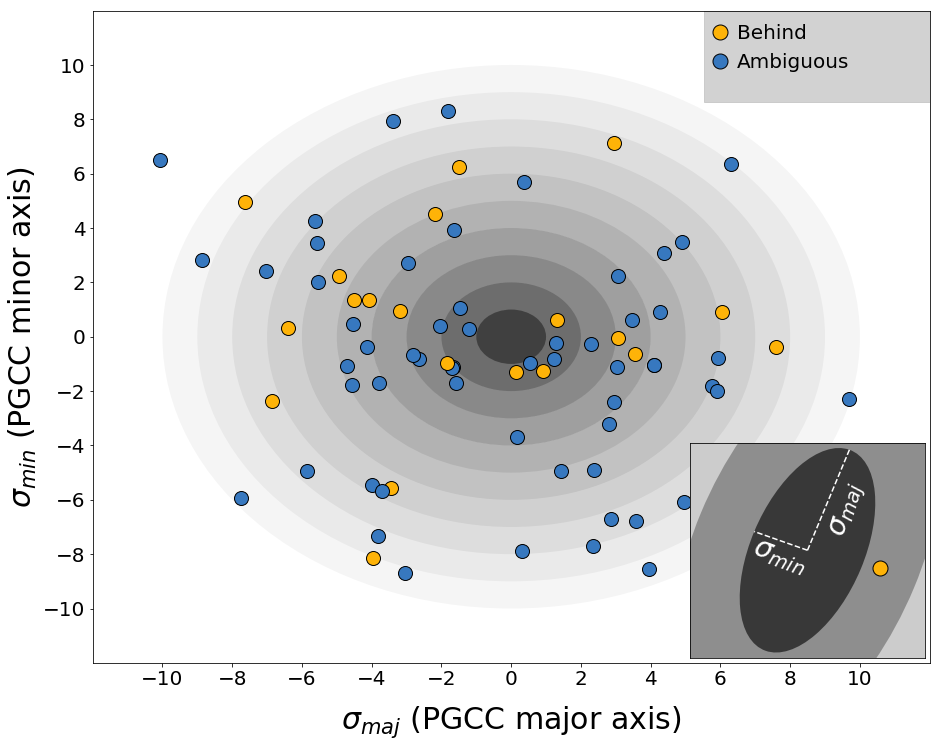

In [56]:
co_bright=['HD62542','HD147683']
radio_co_dark=['HD232522','HD72350','HD124979','CPD-592603','HDE303308','HD152249','HD208440']
uv_co_dark=['HD116781','HD72754','HD37903','HD111934','HD93205']

threesig=[x for x in threesig if x[0][0] in co_bright+radio_co_dark+uv_co_dark]


#fig=plt.figure(1,figsize=(30,20))
#g=gridspec.GridSpec(5,4)
#subplt=plt.subplot(g[:,:3])
#subplt1=plt.subplot(g[3:5,-1])

fig=plt.figure(1,figsize=(15,12))
subplt=plt.subplot(111)
subplt1=inset_axes(subplt,width='28%',height='33%',loc=4)

subplt.set_xlim(-12,12)
subplt.set_ylim(-12,12)
subplt.set_xlabel('$\sigma_{maj}$ (PGCC major axis)',fontsize=30,labelpad=15)
subplt.set_ylabel('$\sigma_{min}$ (PGCC minor axis)',fontsize=30)
subplt.tick_params(axis='x',labelsize=20)
subplt.tick_params(axis='y',labelsize=20)
subplt1.set_xticks([])
subplt1.set_yticks([])
for i in range(1,11):
    ell=Ellipse(xy=(0,0),width=2*i,
                height=2*i
                ,angle=0)
    ell.set_facecolor('k')
    ell.set_alpha(0.4/i)
    subplt.add_patch(ell)
        
for pair in archival_pairs+new_pairs: #threesig+new_pairs:
    sightline=pair[0][0]
    pgcc=pair[1]
    r_dist=get_r_dist(pgcc,pair[0][1][0].value,pair[0][1][1].value)

    ra,dec=pair[0][1]
    galcoord=SkyCoord(ra=ra,dec=dec).galactic
    del_l=60.*(galcoord.l.value-pgcc['glon'])
    del_b=60.*(galcoord.b.value-pgcc['glat'])
    theta=np.arctan(del_b/del_l)
    omega=-pgcc['gau_position_angle']
    phi=theta-omega
    sig_x=r_dist*np.cos(phi)
    sig_y=r_dist*np.sin(phi)
    if del_l<0:
        sig_x=-sig_x
        sig_y=-sig_y
    
    if sightline in new_sightlines:
        col='w'
        sig_x=0.98*sig_x
        sig_y=0.98*sig_y
        #subplt.plot(sig_x,sig_y,marker='o',color=col,ms=14,mec='k')
    elif sightline in primary_sightlines:
        col=amber
        subplt.plot(sig_x,sig_y,marker='o',color=col,ms=14,mec='k')
    elif sightline in in_front_sightlines:
        col='k'
    #elif sightline in uv_co_dark:
    #    col='b'
    else:
        col=blue
        subplt.plot(sig_x,sig_y,marker='o',color=col,ms=14,mec='k')
    #subplt.text(sig_x,sig_y,sightline)

    
#Draws the legend
rect=Rectangle(xy=(0.73,0.86),width=0.27,height=0.205,angle=0,
               transform=subplt.transAxes,color='silver',alpha=0.7)
subplt.add_patch(rect)
subplt.text(0.77,0.98,'Behind\nAmbiguous',
            fontsize=20,linespacing=1.7,ha='left',va='top',transform=subplt.transAxes)
subplt.plot(0.75,0.967,marker='o',color=amber,mec='k',ms=15,transform=subplt.transAxes)
subplt.plot(0.75,0.923,marker='o',color=blue,mec='k',ms=15,transform=subplt.transAxes)
#subplt.plot(0.75,0.878,marker='o',color='w',mec='k',ms=15,transform=subplt.transAxes)
#subplt.plot(0.75,0.81,marker='o',color='w',mec='w',ms=15,transform=subplt.transAxes)
#subplt.text(0,1,'1$\sigma$',fontsize=25,va='bottom',ha='center')
#subplt.text(0,2,'2$\sigma$',fontsize=25,va='bottom',ha='center')
#subplt.text(0,3,'3$\sigma$',fontsize=25,va='bottom',ha='center')


example=threesig[1]
subplt1.set_xlim(-0.5*example[1]['gau_major_axis'],0.5*example[1]['gau_major_axis'])
subplt1.set_ylim(-0.5*example[1]['gau_major_axis'],0.5*example[1]['gau_major_axis'])
for i in range(1,4):
        ell=Ellipse(xy=(0,0),width=i*example[1]['gau_major_axis'],
                    height=i*example[1]['gau_minor_axis'],angle=-(180./np.pi)*example[1]['gau_position_angle'])
        ell.set_facecolor('k')
        ell.set_alpha(0.6/i)
        subplt1.add_patch(ell)
        
gal=SkyCoord(ra=example[0][1][0],dec=example[0][1][1],frame='icrs').galactic
del_l=60.*(gal.l.value-example[1]['glon'])
del_b=60.*(gal.b.value-example[1]['glat'])
#if (((cos*del_l+sin*del_b)/a)**2+((sin*del_l-cos*del_b)/b)**2)<=1.:
subplt1.plot(del_l,del_b,marker='o',color=amber,markersize=15,mec='k')

majx=np.cos(-example[1]['gau_position_angle'])*np.linspace(0,0.5*example[1]['gau_major_axis'],10)
majy=np.sin(-example[1]['gau_position_angle'])*np.linspace(0,0.5*example[1]['gau_major_axis'],10)
subplt1.plot(majx,majy,'w--')
minx=np.cos(-example[1]['gau_position_angle']+np.pi/2.)*np.linspace(0,0.5*example[1]['gau_minor_axis'],10)
miny=np.sin(-example[1]['gau_position_angle']+np.pi/2.)*np.linspace(0,0.5*example[1]['gau_minor_axis'],10)
subplt1.plot(minx,miny,'w--')
subplt1.text(0.25,0.48,'$\sigma_{min}$',
             transform=subplt1.transAxes,color='w',fontsize=28,fontweight='bold',rotation=-20)
subplt1.text(0.58,0.75,'$\sigma_{maj}$',
             transform=subplt1.transAxes,color='w',fontsize=28,fontweight='bold',rotation=73)

ticks=np.arange(-10,11,2)
subplt.set_xticks(ticks)
subplt.set_yticks(ticks)
pass
plt.savefig('/Users/codydirks/Desktop/plots/bullseye1.pdf')

In [36]:
# Results contains:
#    [0]: Sightline, coords
#    [1]: PGCC data
#    [2]: C I components
#    [3]: Total CO column

results=[]
for pair in pairs:
    sightline=pair[0][0]
    res=[x for x in os.listdir(x1d_dir+sightline+'/E140H/') if x.endswith('.txt')]
    cI_results=[x for x in res if x.startswith('cI')]
    co_results=[x for x in res if x.startswith('co')]
    cl_results=[x for x in os.listdir(x1d_dir+sightline+'/E140H/') if x=='clI_results.par']
    #print sightlinetest=threesig[2]
, len(res),cI_results,co_results,cl_results
    co13_results=[x for x in res if x.startswith('13co')]
    ra,dec=pair[0][1]
    sightline_gal=SkyCoord(ra=ra,dec=dec).galactic
    
    cI_comps=[]
    if len(cI_results)>0:
        cI_dat=open(x1d_dir+sightline+'/E140H/'+cI_results[0])
        lines=[x.strip() for x in cI_dat.read().split('\n')]
        for i in range(len(lines)):
            if lines[i].startswith('*'):
                idx=i+1
                c0=LineInfo(lines[idx],lines[idx+1])
                c1=LineInfo(lines[idx+2],lines[idx+3])
                c2=LineInfo(lines[idx+4],lines[idx+5])
                comp=(c0,c1,c2)
                cI_comps.append(comp)
    
    co_N=0.0
    co_N_err=0.0
    co_vel=-9999
    cl_N=0.0
    if len(co_results)>0:# and len(cl_results)>0:
        co_dat=open(x1d_dir+sightline+'/E140H/'+co_results[0])
        lines=[x.strip() for x in co_dat.read().split('\n')]
        co_vel=float(lines[2].strip().split()[4])
        for line in lines:
            if line.startswith('total'):
                line_data=line.split('error')
                co_N=float(line_data[0].strip().split('=')[1].strip())
                co_N_err=float(line_data[1].split('=')[1].strip())
                break
        
        del_v=9999
        nearest=[0,0]
        #cl_dat=open(x1d_dir+sightline+'/E140H/'+cl_results[0])
        #lines=[x.strip() for x in cl_dat.read().strip('\n').split('\n')]
        #for line in lines[1:]:
        #    n=float(line.strip().split()[1])
        #    vel=float(line.strip().split()[3])
        #    if abs(co_vel-vel)<del_v:
        #        del_v=abs(co_vel-vel)
        #        nearest=[n,vel]
            
    results.append((pair[0],pair[1],cI_comps, [co_N,co_N_err,co_vel],nearest))
for x in results:
    print x[0][0],x[1]['dist'],x[3][0]

HD36959 0.415 0.0
HD208440 0.54 1.7323e+14
HD62542 0.0 9.0333e+15
HD116781 2.3 0.0
HD232522 0.264241 5.1242e+13
HD72754 0.0 0.0
HD72350 1.09 1.2721e+14
HD44173 0.0 0.0
HD37903 0.415 0.0
HD124979 0.0 1.5955e+14
CPD-592603 3.13 8.5657e+13
HD111934 -2.31 0.0
HD147683 0.0 7.7572e+14
HD93206 3.13 0.0
HD93205 3.13 0.0
HD72089 0.0 0.0
HDE303308 3.13 6.3177e+13
HD152249 0.0 1.4115e+14
HD24534 0.14 2.0036e+16
HD108610 8.23 0.0
HD93222 3.13 2.609e+13
HD13841 0.53 0.0
HD138679 0.76 0.0
HD106343 3.01 0.0
HD114886 1.64 5.5049e+13
HD192577 0.0 0.0
HD208816 0.0 0.0
HD42111 0.415 0.0
HD110434 0.0 0.0
HD40893 0.0 0.0
HD101436 2.15 1.6226e+14
HD137595 0.0 6.6015e+13
HD124314 0.0 1.3763e+14
HD203532 0.0 9.5054e+14
HD186688 0.0 0.0
HD203374 0.0 1.0004e+15
HD69106 6.06 0.0
HD15137 0.0 0.0
HD23180 0.14 3.0681e+14
HD208947 0.0 1.2299e+14
HD101131 2.15 6.831e+13
HD100546 0.0 0.0
HD115071 8.24 4.0905e+14
HD37367 0.185353 0.0
HD122879 2.55 0.0
HD108002 -0.83 0.0
HD1383 0.0 0.0
HD37021 0.415 0.0
HD46300 0.98 0.0

In [ ]:
cos=[x for x in results if x[3][0]>0.0 and x[1]['gau_major_axis']>0]
print len(cos)

In [ ]:
fig=plt.figure(2,figsize=(12,9))
subplt1=plt.subplot(311)
#subplt2=plt.subplot(312)
#subplt3=plt.subplot(313)
#subplt2.set_xlabel('Distance from center (sigma)')
subplt1.set_xlim(0,8)
#subplt2.set_xlim(0,8)
#subplt3.set_xlim(0,8)
subplt1.set_ylabel('N(CO)')
subplt1.set_yscale('log')
#subplt2.set_yscale('log')
#subplt3.set_yscale('log')
for co in cos:
    r_dist=get_r_dist(co[1],co[0][1][0].value,co[0][1][1].value)
    
    subplt1.plot(r_dist,co[3][0],'ko')
    subplt1.text(r_dist+0.05,co[3][0],co[0][0])
    
    #subplt2.errorbar(r_dist, co[3][0],yerr=co[3][1],marker='o',color='k')
    #subplt2.text(r_dist+0.05,co[3][0],co[0][0])
    
    #subplt3.plot(r_dist, co[4][0],'ko')
#plt.savefig('CO_vs_sigma.pdf')

In [37]:
results.sort(key=lambda x: get_r_dist(x[1],x[0][1][0].value,x[0][1][1].value))
i=1
for result in pairs:
    r=get_r_dist(result[1],result[0][1][0].value,result[0][1][1].value)
    if r<3:
        print i,result[0][0],r
        i=i+1

/home/cody/python/lib/python2.7/site-packages/ipykernel/__main__.py:70: RuntimeWarning: divide by zero encountered in double_scalars


1 HD36959 1.0973926808
2 HD208440 1.23199150565
3 HD62542 1.30295173934
4 HD116781 1.30459200395
5 HD232522 1.44372706738
6 HD72754 1.47515829577
7 HD72350 1.56097682131
8 HD44173 1.71236374401
9 HD37903 1.82174761647
10 HD124979 2.02295014902
11 CPD-592603 2.05640784395
12 HD111934 2.07267255656
13 HD147683 2.08262817268
14 HD93206 2.30241671484
15 HD93205 2.31044526772
16 HD72089 2.57819428775
17 HDE303308 2.76026144298
18 HD152249 2.90292747742


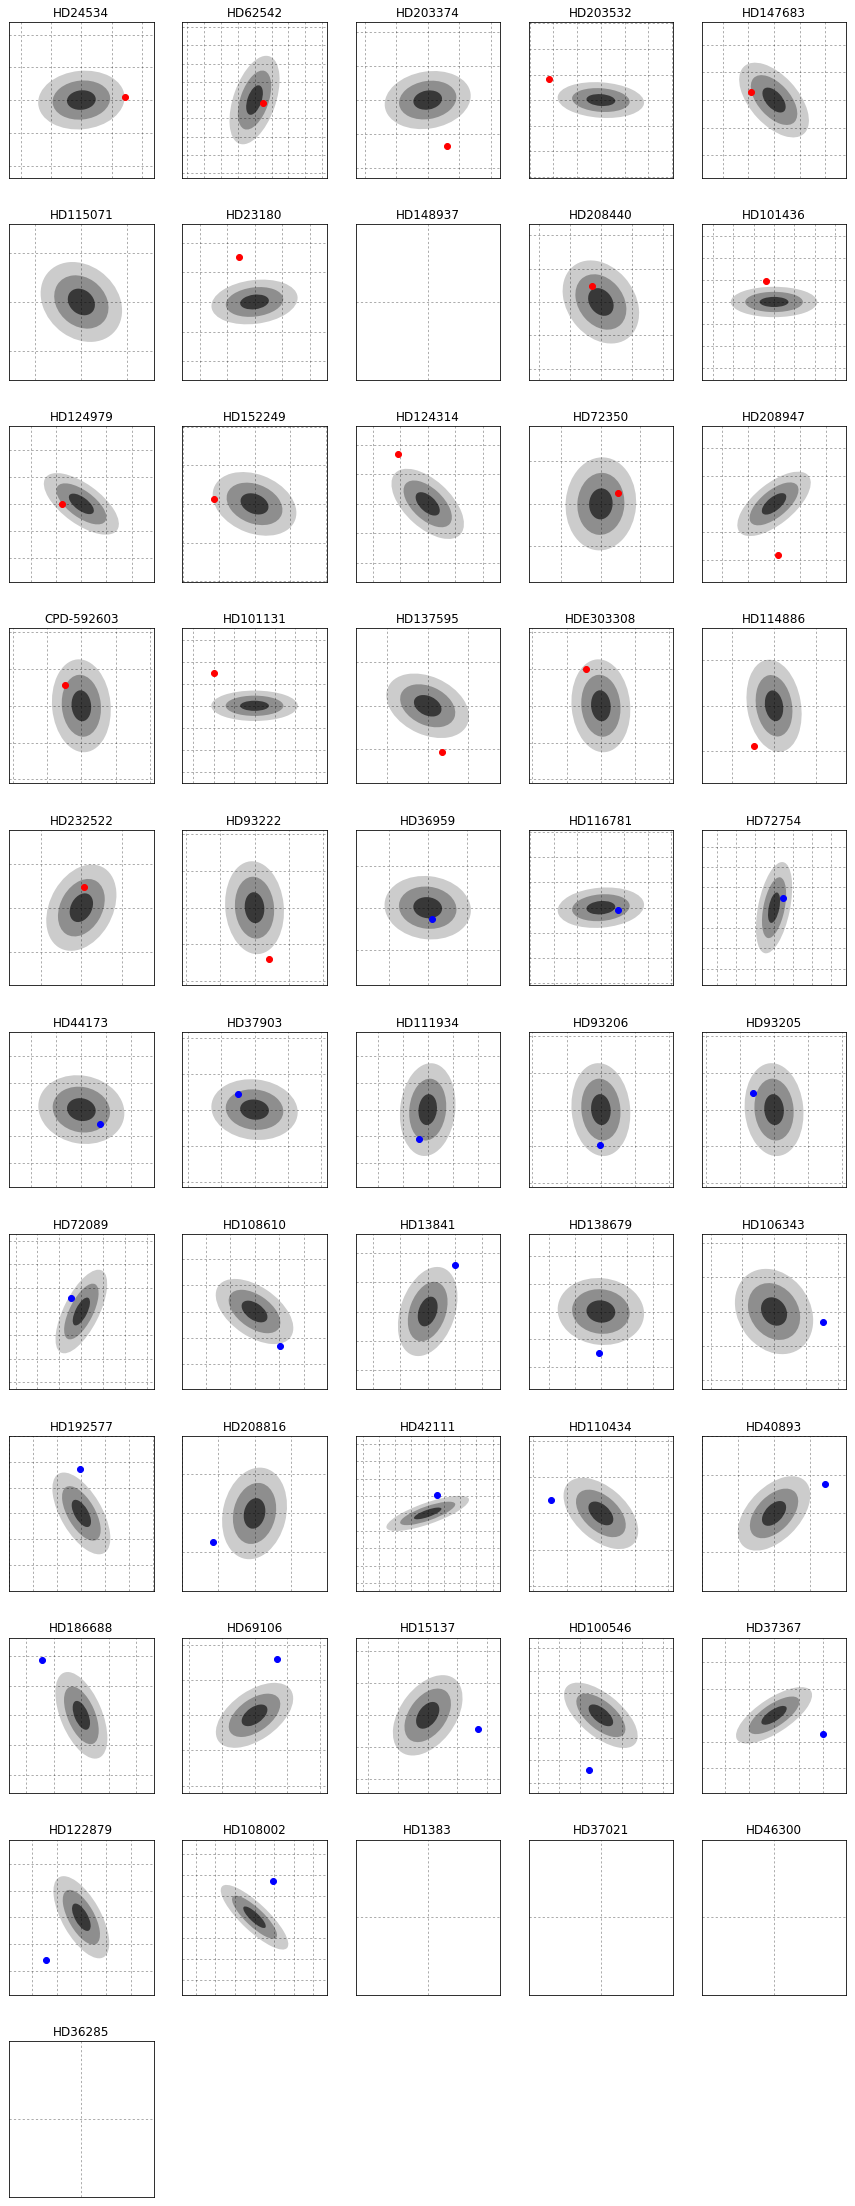

In [45]:
fig=plt.figure(1,figsize=(15,40))
k=1
results.sort(key=lambda x: x[3],reverse=True)
plt.subplots_adjust(hspace=0.3)
for result in results:#[x for x in results if x[1]['gau_major_axis'] > 0]:
    subplt=plt.subplot(11,5,k)
    k=k+1
    
    # Format each subplot range, grid lines, and axes properties
    subplt.set_title(result[0][0])
    subplt.set_xlim(-2.5*result[1]['gau_major_axis'],2.5*result[1]['gau_major_axis'])
    subplt.set_ylim(-2.5*result[1]['gau_major_axis'],2.5*result[1]['gau_major_axis'])
    tick=ticker.MultipleLocator(base=10.0)
    subplt.xaxis.set_major_locator(tick)
    subplt.yaxis.set_major_locator(tick)
    subplt.grid(True,linestyle=':',color='k',alpha=0.4)
    subplt.get_xaxis().set_ticklabels([])
    subplt.get_yaxis().set_ticklabels([])
    subplt.tick_params(length=0)
    
    for i in range(1,4):
        ell=Ellipse(xy=(0,0),width=i*result[1]['gau_major_axis'],
                    height=i*result[1]['gau_minor_axis'],angle=-(180./np.pi)*result[1]['gau_position_angle'])
        ell.set_facecolor('k')
        ell.set_alpha(0.6/i)
        subplt.add_patch(ell)
        
    ra,dec=result[0][1]
    galcoord=SkyCoord(ra=ra,dec=dec).galactic
    if result[3][0]>0:
        c='r'
    else:
        c='b'
    subplt.plot(60.*(galcoord.l.value-result[1]['glon']),60.*(galcoord.b.value-result[1]['glat']),marker='o',color=c)

In [28]:
sightline

'HD220058'